In [1]:
# the building we want to run
building_id = 3
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 40
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-cost"
number_of_opt_evaluations = 100
run_i = 7
iteration = 68
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,building_id,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,building_id,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,building_id,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
import time
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    try:
      if not os.path.exists(directory):
          os.makedirs(directory)
    except:
      time.sleep(10)
      if not os.path.exists(directory):
          os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


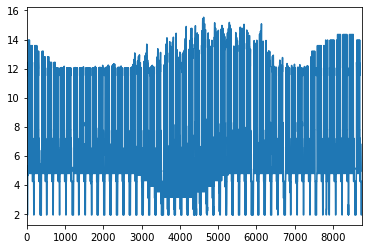

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.56
14.35221199000051


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

energy_plus/output_energy_plus/rbf-cost-106-2-7/eplusout.sql
Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.918943881988525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.030296564102173 sec


ERROR:root:Finished Generation of Irradiance


0.0


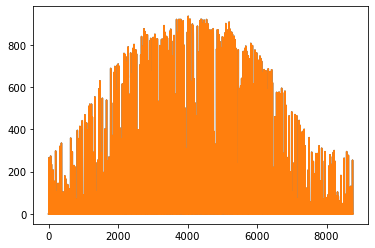

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,845 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.56


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


{'name': 'gurobi', 'options': None}
Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.829423427581787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.979602098464966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.970888376235962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


INFO:root:Constraint: calc_investment_cost


INFO:root:Constraint: calc_maintenance_cost


INFO:root:Constraint: calc_operating_cost


INFO:root:Constraint: calc_total_carbon


INFO:root:Constraint: calc_total_cost


INFO:root:Constraint: constrain_max_energy


INFO:root:Constraint: daily_c_lower_medlar


INFO:root:Constraint: daily_c_lower_small


INFO:root:Constraint: daily_c_upper_medlar


INFO:root:Constraint: daily_c_upper_small


INFO:root:Constraint: energy_balance


INFO:root:Constraint: force_install


INFO:root:Constraint: large_lower


INFO:root:Constraint: large_operating_export_lower


INFO:root:Constraint: large_operating_export_upper


INFO:root:Constraint: large_operating_import_lower


INFO:root:Constraint: large_operating_import_upper


INFO:root:Constraint: large_upper


INFO:root:Constraint: max_carbon_level


INFO:root:Constraint: max_track_constraint


INFO:root:Constraint: med_operating_export_lower


INFO:root:Constraint: med_operating_export_upper


INFO:root:Constraint: med_operating_import_lower


INFO:root:Constraint: med_operating_import_upper


INFO:root:Constraint: medium_lower


INFO:root:Constraint: medium_upper


INFO:root:Constraint: monthly_bill_lower


INFO:root:Constraint: monthly_bill_upper


INFO:root:Constraint: monthly_export_constraint


INFO:root:Constraint: monthly_import_constraint


INFO:root:Constraint: net_metering_constraint


INFO:root:Constraint: roof_tech_area_below_max


INFO:root:Constraint: roof_tech_area_definition


INFO:root:Constraint: roof_tech_cap_max


INFO:root:Constraint: small_demand_charge_constraint


INFO:root:Constraint: small_operating_export_lower


INFO:root:Constraint: small_operating_export_upper


INFO:root:Constraint: small_operating_import_lower


INFO:root:Constraint: small_operating_import_upper


INFO:root:Constraint: storage_balance


INFO:root:Constraint: storage_charge_rate


INFO:root:Constraint: storage_discharge_rate


INFO:root:Constraint: storage_input_positive


INFO:root:Constraint: storage_is_installed


INFO:root:Constraint: storage_is_installed_2


INFO:root:Constraint: storage_level_above_minimum


INFO:root:Constraint: storage_level_below_capacity


INFO:root:Constraint: storage_level_positive


INFO:root:Constraint: storage_looping


INFO:root:Constraint: storage_output_positive


INFO:root:Constraint: tech_export_positive


INFO:root:Constraint: tech_import_positive


INFO:root:Constraint: tech_input_below_capacity


INFO:root:Constraint: tech_input_positive


INFO:root:Constraint: tech_is_installed


INFO:root:Constraint: tech_is_installed_2


INFO:root:Constraint: tech_is_on


INFO:root:Constraint: tech_is_on_2


INFO:root:Constraint: tech_part_loads


INFO:root:Constraint: total_export_value_constraint


INFO:root:Constraint: total_import_value_constraint


INFO:root:Constraint: total_roof_area_definition


INFO:root:Constraint: track_above_150_constraint_lower


INFO:root:Constraint: track_above_150_constraint_upper


INFO:root:Constraint: track_above_35_constraint_lower


INFO:root:Constraint: track_above_35_constraint_upper


INFO:root:Constraint: track_above_550_constraint_lower


INFO:root:Constraint: track_above_550_constraint_upper


INFO:root:Constraint: track_any_above_150_constraint_lower


INFO:root:Constraint: track_any_above_150_constraint_upper


INFO:root:Constraint: track_any_above_35_constraint_lower


INFO:root:Constraint: track_any_above_35_constraint_upper


INFO:root:Constraint: track_or_constraint_lower


INFO:root:Constraint: track_or_constraint_upper


INFO:root:Constraint: track_or_constraint_upper2


INFO:root:Constraint List: capacity_bounds


ERROR:ga_logger:Recompiled the model in 254 s


ERROR:ga_logger:Starting solver


None


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [307.53518498812736, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.5574048188814


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


Total Electricity Imported from the grid 50,271 kWh
At a cost of $ 0.1253 /kWh
Total Cost of the system: $ 3,188 per year


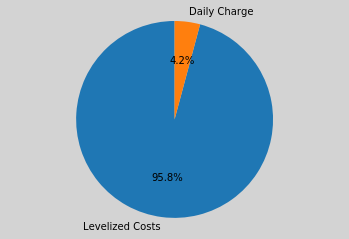

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings={
                    'name': 'gurobi',
                    'options':None
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=1.5,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

50270.728631185906

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr     3953.588272
Aug     4232.535574
Dec     4728.407874
Feb     4220.904101
Jan     4695.625513
Jul     3596.797122
Jun     3505.544383
Mar     4553.295110
May     3930.927926
Nov     4284.410932
Oct     4521.675077
Sep     4047.016748
monthly_import    50270.728631
dtype: float64
50270.728631185906
     monthly_export
Apr     6047.180913
Aug     6614.423308
Dec      804.969294
Feb     2251.160819
Jan      895.761370
Jul     7708.016021
Jun     6371.405780
Mar     3649.482470
May     7091.115573
Nov      925.105855
Oct     2596.898286
Sep     5315.108943
monthly_export    50270.628631
dtype: float64
50270.62863118734
133.0424999999616


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.0424999999616

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng           1.0
Grid               1.0
Invertor           1.0
PV0                1.0
PV1                0.0
PV2                0.0

In [23]:
my_model.solveResults['solution']['any_above_35']

0.0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0.0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings,
                         force_install=False)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 100


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (187.70030405900752, 158.40695313334078, 98.557088678568, 14.529869595614617, 1.8840570996394996, 25.251275086216882, 0.3912623086151259, 0.28444462195270825, 0.38535147338758335)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 188
                                           a tilt of 14.5
                                           and a gcr of 0.391


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.364450454711914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 158
                                           a tilt of 1.9
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.698086261749268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 25.3
                                           and a gcr of 0.385


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.193828344345093 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 259 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [234.27287768900058, 0.0, 0.0]


ERROR:ga_logger:Cost: 4252.154017127005


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


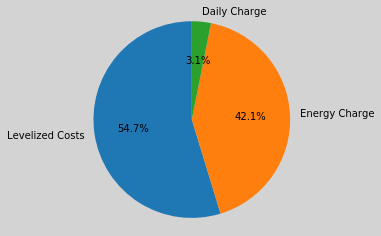

ERROR:ga_logger:panel values: (243.74076429308383, 177.9186586593089, 148.37927727013178, 23.301825126229, 55.977998682153085, 2.9740867336139196, 0.5034118933692562, 0.6580691533860783, 0.4963930685767947)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 244
                                           a tilt of 23.3
                                           and a gcr of 0.503


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.045417308807373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 56.0
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.19354772567749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 3.0
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.731945514678955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 257 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 129.0661248704763, 199.86431358782357]


ERROR:ga_logger:Cost: 3400.059336822778


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


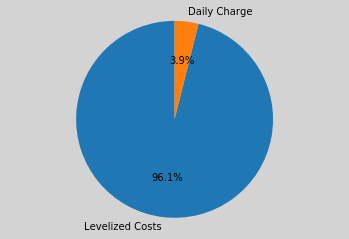

ERROR:ga_logger:panel values: (96.6873341884797, 220.1270329410842, 222.60381140016483, 39.96984328734835, 23.658493301448143, 19.229395301592163, 0.7211902397696164, 0.3736599324332097, 0.6323416322512876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 97
                                           a tilt of 40.0
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.977333068847656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 23.7
                                           and a gcr of 0.374


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.246913433074951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 19.2
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.121810674667358 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 281 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 93.24201904991259, 220.82923639822528]


ERROR:ga_logger:Cost: 3252.4749551243176


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


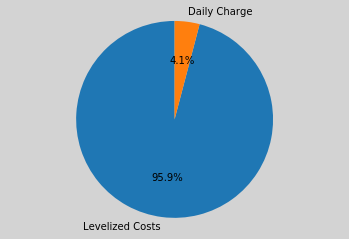

ERROR:ga_logger:panel values: (228.60316663301373, 117.11582481053773, 188.36758833440763, 10.744850079260576, 16.51623053885048, 48.48401886763423, 0.8532340017333877, 0.5432671849233193, 0.8398590738674219)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 10.7
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.865063905715942 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 16.5
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.052205562591553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 48.5
                                           and a gcr of 0.840


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.427860736846924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 273 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [6.666733334000007e-06, 323.7152582744135, 0.0]


ERROR:ga_logger:Cost: 3348.261179138317


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


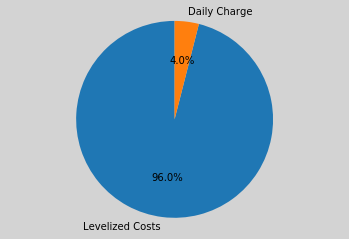

ERROR:ga_logger:panel values: (138.59927201313195, 257.7436924179372, 251.43672473345296, 53.445673699451405, 36.393228017472175, 39.05941014597002, 0.20500408950495846, 0.8922674794741066, 0.25946612484213255)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 53.4
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.9638285636901855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 36.4
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.008053541183472 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 251
                                           a tilt of 39.1
                                           and a gcr of 0.259


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2092444896698 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 289 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [37.121445351499254, 372.6868065985517, 0.0]


ERROR:ga_logger:Cost: 4203.353947968562


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


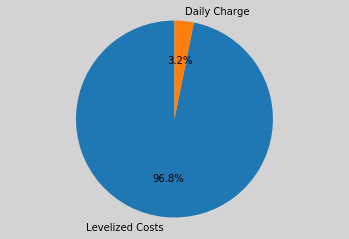

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.751160621643066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.841810464859009 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.115453243255615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 291 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.16115923082754]


ERROR:ga_logger:Cost: 3084.5205097866624


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


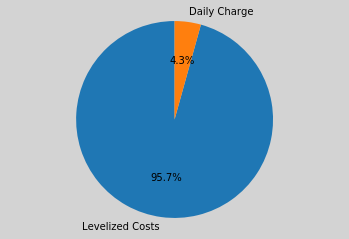

ERROR:ga_logger:panel values: (95.51709500710649, 90.54755316575034, 91.26411617616284, 54.85855383779845, 55.616492658094046, 54.3528678141798, 0.2394416061490863, 0.20440180017956025, 0.8878236626326721)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 54.9
                                           and a gcr of 0.239


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.264930248260498 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 55.6
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.016387462615967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 54.4
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.885699987411499 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 297 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.4683235868402709, 0.0, 529.8582954553206]


ERROR:ga_logger:Cost: 5400.366488953912


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


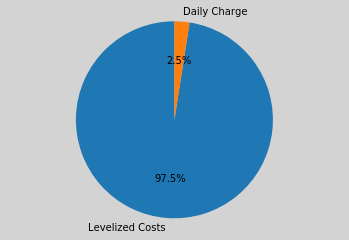

ERROR:ga_logger:panel values: (91.9843787572769, 92.39036454691833, 90.82154807102816, 51.576694144746526, 3.468283192309819, 1.1505069659158786, 0.891147542836245, 0.8998871245509137, 0.2022574398173098)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 51.6
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.163660287857056 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 3.5
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.061358690261841 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.2
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.83096981048584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 308 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 278.28913046463174, 58.556107830735456]


ERROR:ga_logger:Cost: 3478.670691306531


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


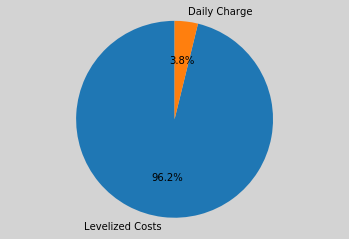

ERROR:ga_logger:panel values: (91.20373575151717, 255.08060531328272, 100.0332452523001, 1.0347937918531365, 55.081202984768005, 55.773455608414594, 0.8928797857418493, 0.8917822434329732, 0.22876279434598384)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.0
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.54090428352356 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 55.1
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.06982159614563 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 55.8
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.161805629730225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 301 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [335.90749574448404, 0.0, 0.0]


ERROR:ga_logger:Cost: 3469.3568444076477


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


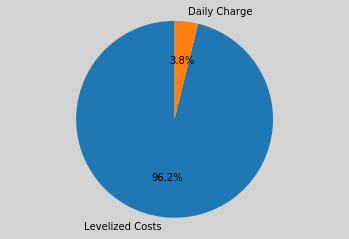

ERROR:ga_logger:panel values: (149.39820428234674, 149.31198329876122, 205.86244511732497, 19.601938447213033, 37.34529685431318, 19.671151433538622, 0.43708370299854704, 0.6581464917341946, 0.43526846678639575)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 19.6
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.080793142318726 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 37.3
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.004972219467163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 19.7
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.174011945724487 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 303 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [165.25978526405626, 145.23006460295548, 0.0]


ERROR:ga_logger:Cost: 3216.9037269132373


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


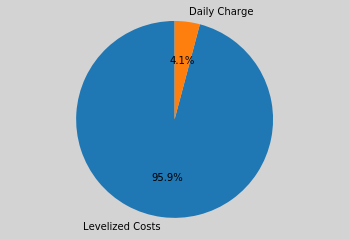

ERROR:ga_logger:panel values: (149.408482129445, 205.23676953506993, 149.3176068072736, 19.504409821728913, 19.457030652663267, 19.93731014228664, 0.434668765880849, 0.6647937981396841, 0.6647880382892206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 19.5
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.144613742828369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 19.5
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.362751722335815 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 19.9
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.284632682800293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 306 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [173.84596659912367, 132.16847641894273, 0.0]


ERROR:ga_logger:Cost: 3172.4530848649765


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


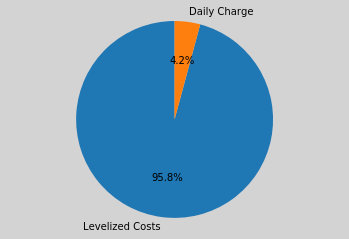

ERROR:ga_logger:panel values: (183.22194350494968, 264.99999999987494, 264.999999999961, 1.0000000000138531, 14.293732441984618, 1.0000000000087652, 0.8999999999999222, 0.8999999999998824, 0.8999999999996382)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.289341449737549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 14.3
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.234796762466431 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.287494421005249 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  18 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 306 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [333.3338546118639, 0.0, 0.0]


ERROR:ga_logger:Cost: 3443.794926714324


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


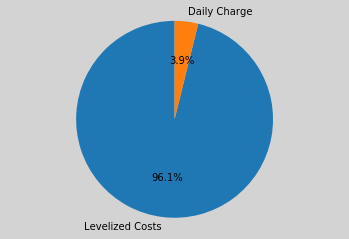

ERROR:ga_logger:panel values: (256.5348088871041, 99.39534198906642, 253.37920737004026, 48.694309873114776, 9.669863395597796, 1.497369564073643, 0.8996248728186012, 0.8846754198464235, 0.2713464367390118)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 48.7
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.890129804611206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 9.7
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.925378799438477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 253
                                           a tilt of 1.5
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.902628660202026 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 304 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 259.24035756126875, 82.95800016877811]


ERROR:ga_logger:Cost: 3531.838945316772


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


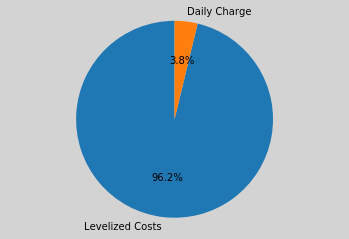

ERROR:ga_logger:panel values: (109.14548035622376, 247.4995923334149, 170.24341933781085, 15.857787816586622, 52.12312323191585, 1.922576846510403, 0.898892891120864, 0.8872782431551407, 0.5457846809544031)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 15.9
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.196254730224609 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 52.1
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.357641935348511 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 1.9
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.174694538116455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 305 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [11.469501742126747, 0.0, 319.8309661958521]


ERROR:ga_logger:Cost: 3423.5989245011874


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


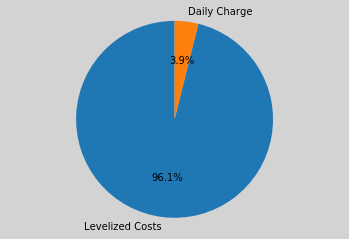

ERROR:ga_logger:panel values: (114.81756122533113, 163.19902557528084, 224.06300212294192, 4.065517764088696, 11.669775410256506, 37.19216303997373, 0.8928884624631459, 0.8927348258486796, 0.5579991521456467)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 4.1
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.87420392036438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 11.7
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3398308753967285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 224
                                           a tilt of 37.2
                                           and a gcr of 0.558


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3535168170928955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 303 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 322.33576404468465, 0.0]


ERROR:ga_logger:Cost: 3334.559703968701


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


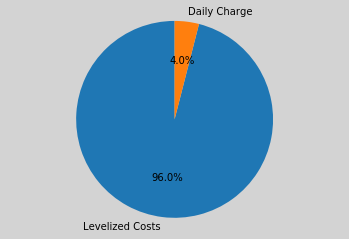

ERROR:ga_logger:panel values: (184.09599723964624, 199.8770075880969, 205.38634390991137, 20.709545406042132, 27.172050009516774, 19.51597057289632, 0.6644819894510304, 0.6648213614457161, 0.664882959087218)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 20.7
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.374428033828735 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 27.2
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.181453704833984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 19.5
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.909718751907349 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 284 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [302.4715597417231, 0.0, 0.0]


ERROR:ga_logger:Cost: 3137.2644638733477


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


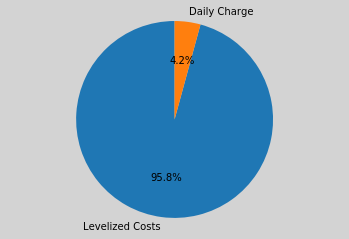

ERROR:ga_logger:panel values: (150.1356761355765, 176.63616238299005, 161.6329634732155, 28.951888748544913, 28.784795197837983, 23.202354704546888, 0.664566693967111, 0.6654887361493352, 0.5695072329458832)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 29.0
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.20966100692749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 28.8
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.968955039978027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 23.2
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.881417751312256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 283 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.4995503685731]


ERROR:ga_logger:Cost: 3127.610272740212


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


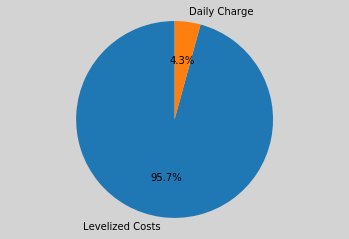

ERROR:ga_logger:panel values: (175.2023653184911, 191.15232732729578, 193.39598686732552, 23.368332276407983, 29.12649987851029, 29.144781304597267, 0.5929059256575115, 0.5641038391121955, 0.5812664066871353)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 23.4
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1244871616363525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 29.1
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.055527448654175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 29.1
                                           and a gcr of 0.581


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1308300495147705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 283 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 298.47767793830843, 0.0]


ERROR:ga_logger:Cost: 3097.596437307133


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


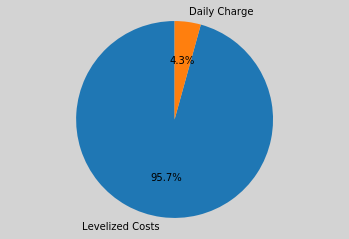

ERROR:ga_logger:panel values: (260.8528067570754, 248.66199245570044, 93.13607024896947, 55.39206571131109, 2.4216242420833374, 1.7279582535797713, 0.8886966401711687, 0.898201024525149, 0.8911103042689774)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 55.4
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.896639347076416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 2.4
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.819390773773193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 1.7
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.0140221118927 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 276 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 334.81534544416525, 0.0]


ERROR:ga_logger:Cost: 3458.5093898532914


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


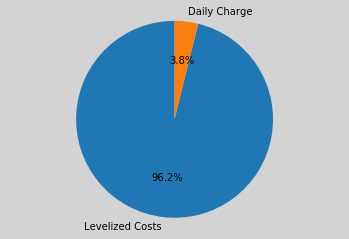

ERROR:ga_logger:panel values: (99.13518095709128, 95.63363847429278, 261.90929694555285, 51.512790595123754, 1.8869486521603958, 2.2729251777543555, 0.897107373954497, 0.8978909601858938, 0.8927942435665133)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 99
                                           a tilt of 51.5
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1193459033966064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 1.9
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.822817087173462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 2.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.83073353767395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 270 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 335.6084166420018, 0.0]


ERROR:ga_logger:Cost: 3466.386331210464


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


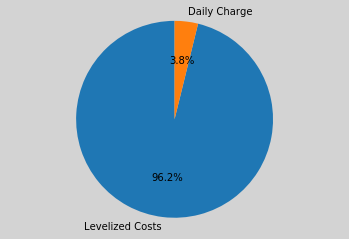

ERROR:ga_logger:panel values: (204.97753122295433, 126.18779498012049, 234.0670337952834, 49.8048016743158, 3.5441756954630703, 24.440872649089314, 0.8956771537524528, 0.5409325006901438, 0.728251784071031)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 49.8
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.799997329711914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 126
                                           a tilt of 3.5
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.152297735214233 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 24.4
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.303311109542847 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 297 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 306.8213633617761, 22.978861024884992]


ERROR:ga_logger:Cost: 3408.6982068917014


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


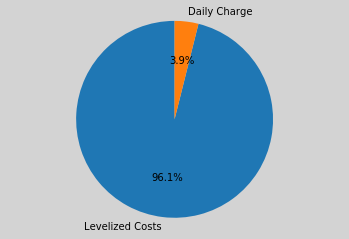

ERROR:ga_logger:panel values: (200.06548872420257, 171.22032676290073, 189.58471058214093, 31.590489556087334, 22.689779993336465, 19.45020192879646, 0.5279796969249264, 0.6564413247672417, 0.6628332565514432)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 31.6
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.620356321334839 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 22.7
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.417077302932739 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 19.5
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.405287027359009 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 268 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [300.76107683317997, 0.0, 0.0]


ERROR:ga_logger:Cost: 3120.275612235507


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


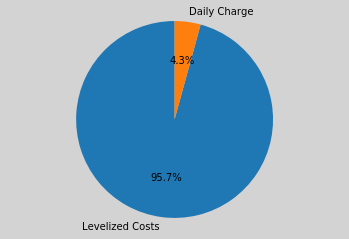

ERROR:ga_logger:panel values: (182.55823669052782, 177.846059728154, 182.00513417743375, 27.863360607418798, 29.363714385693434, 24.886724121760746, 0.5744048450650641, 0.6039269601645203, 0.5812106814184853)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 27.9
                                           and a gcr of 0.574


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.074555158615112 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 29.4
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.052740573883057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 24.9
                                           and a gcr of 0.581


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2084925174713135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 256 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [296.8640782261097, 0.0, 0.0]


ERROR:ga_logger:Cost: 3081.5698419867067


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


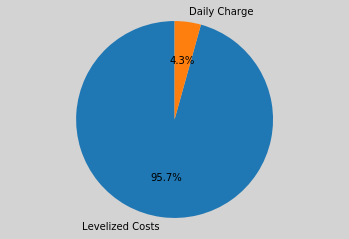

ERROR:ga_logger:panel values: (177.94861782179768, 179.30782345086362, 181.26885022678175, 28.485535470559913, 28.23774235495911, 26.56111366608958, 0.568605300085625, 0.5756689336497098, 0.5716950868214705)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.569


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.9882848262786865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 28.2
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.350194931030273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 26.6
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.406800746917725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 255 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.76839234525806]


ERROR:ga_logger:Cost: 3080.619469578284


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


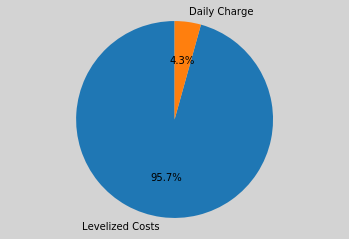

ERROR:ga_logger:panel values: (185.64588900210748, 209.90407245687294, 185.89294128850804, 34.564574735475105, 27.882337353637755, 28.504344162672165, 0.5448998902652757, 0.6602266067579279, 0.46873814126472985)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 34.6
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.216228723526001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 27.9
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.204584836959839 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 28.5
                                           and a gcr of 0.469


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.696221113204956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 253 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [105.88795026733413, 0.0, 189.57465811310212]


ERROR:ga_logger:Cost: 3067.650164420969


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


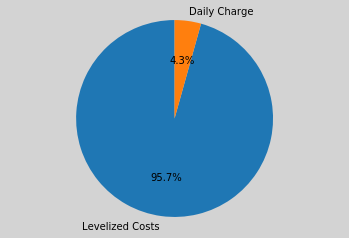

ERROR:ga_logger:panel values: (175.3740518880824, 187.26035929957345, 181.06679107267615, 32.14809840513047, 33.378353359425766, 25.855632946155364, 0.5534234041019719, 0.5498492362746248, 0.6135255579353485)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 32.1
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.466029644012451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 33.4
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.483554840087891 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 25.9
                                           and a gcr of 0.614


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.293999910354614 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 285 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 297.4347221103326, 0.0]


ERROR:ga_logger:Cost: 3087.2375951122303


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


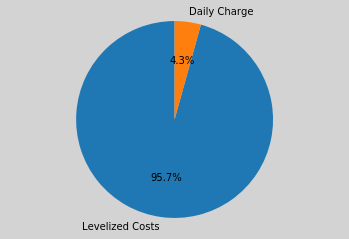

ERROR:ga_logger:panel values: (172.49329153039747, 176.3870972377792, 188.25424623333748, 28.44832964495254, 28.78448445810728, 24.8751028781834, 0.5513025269287386, 0.574487642353487, 0.5524175288789968)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 28.4
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.318876028060913 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.8
                                           and a gcr of 0.574


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.07490873336792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 24.9
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.498677968978882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 286 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [297.69834728602126, 0.0, 0.0]


ERROR:ga_logger:Cost: 3089.855968754982


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


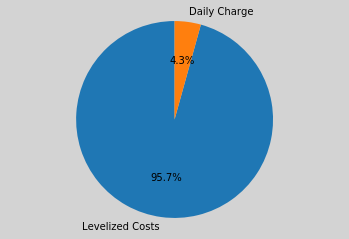

ERROR:ga_logger:panel values: (179.7776733815371, 177.13968998859303, 183.5878564664497, 29.340074356804923, 28.450962446494707, 27.018256693252404, 0.5840074163320546, 0.5722451700236779, 0.5671682912738372)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 29.3
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.869154453277588 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 28.5
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.344585180282593 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 27.0
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.349564552307129 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 304 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.9272955399301]


ERROR:ga_logger:Cost: 3082.1977281105296


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


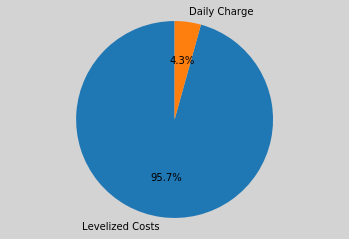

ERROR:ga_logger:panel values: (178.8527144982058, 180.31051932470444, 180.5846339806063, 28.394845753219602, 28.131412699535524, 25.96161456859846, 0.5719692126402379, 0.5694395095599541, 0.5681209670341449)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 28.4
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.976330280303955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 28.1
                                           and a gcr of 0.569


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.237154006958008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 26.0
                                           and a gcr of 0.568


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.263224840164185 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 292 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 296.29238059051744, 0.0]


ERROR:ga_logger:Cost: 3075.891627040297


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


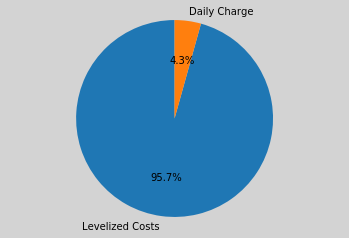

ERROR:ga_logger:panel values: (262.12337547950926, 257.096306375378, 101.73603741440125, 3.09938915592711, 19.15825445395081, 53.52951598582312, 0.8858515296342344, 0.8648835211492467, 0.5137393217116468)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 3.1
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.204288721084595 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 19.2
                                           and a gcr of 0.865


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.131370782852173 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 53.5
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.250825881958008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 302 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [336.74603928001966, 0.0, 0.0]


ERROR:ga_logger:Cost: 3477.6854267834906


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


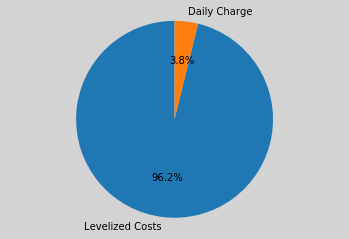

ERROR:ga_logger:panel values: (256.16517497171947, 257.27663952572544, 262.2625273368443, 32.296287708833674, 46.12439196102249, 1.9430675929059622, 0.8865299203542061, 0.21114806634400832, 0.2530227684943996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 32.3
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.516570568084717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 46.1
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.4125895500183105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 1.9
                                           and a gcr of 0.253


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.136690616607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [337.7522976653952, 0.0, 55.103116377155]


ERROR:ga_logger:Cost: 4034.9749663999937


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


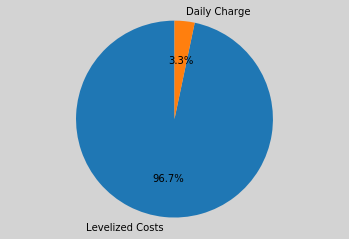

ERROR:ga_logger:panel values: (118.9254555861295, 264.9038712865765, 146.24315575341151, 47.86449347929657, 2.776077458505145, 1.905338146569984, 0.8978856738826637, 0.8907305839924087, 0.5457816914942322)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 47.9
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.646251678466797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 2.8
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.112532615661621 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 1.9
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.129034996032715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 302 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 11.999220840062085, 319.44082209533036]


ERROR:ga_logger:Cost: 3424.9852109346302


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


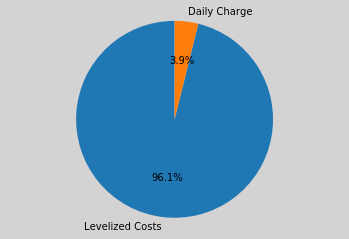

ERROR:ga_logger:panel values: (192.96361370575448, 229.4239352126287, 157.46862990169694, 32.7475738730342, 28.51929411735897, 21.211422592512182, 0.6063299706832582, 0.5625530359870938, 0.5762225742457012)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 193
                                           a tilt of 32.7
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.390488624572754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 28.5
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.028857231140137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 21.2
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.213782548904419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 268 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [301.72772752584865, 0.0, 0.0]


ERROR:ga_logger:Cost: 3129.8765830150264


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


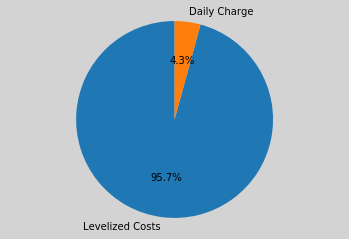

ERROR:ga_logger:panel values: (214.42275767157486, 181.1980340537101, 157.0425780060348, 43.26838558428796, 36.83009617183289, 36.872510787979195, 0.5410103080966984, 0.6474088201708768, 0.3540464861390107)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 43.3
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.6602442264556885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 36.8
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.343484163284302 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 36.9
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.260289430618286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 258 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 194.4959572809281, 105.62605853674859]


ERROR:ga_logger:Cost: 3113.928336021903


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


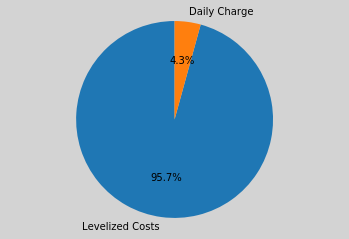

ERROR:ga_logger:panel values: (264.9999999972522, 90.00000000248512, 123.38676338582384, 55.99999999976771, 55.9999999935558, 1.0000000002675242, 0.4161959710776043, 0.2000000000036424, 0.2000000000093976)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.416


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.545023202896118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.591526746749878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 123
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.762110948562622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 268 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [249.20219934318274, 0.0, 0.0]


ERROR:ga_logger:Cost: 5854.402340697918


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


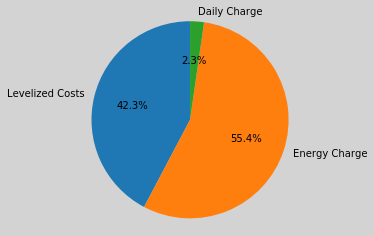

ERROR:ga_logger:panel values: (258.9118981126957, 116.91361199494598, 264.08232912367896, 3.267492078185078, 55.56947984071849, 55.762168017628774, 0.8980614881601883, 0.8952821439925844, 0.2283591651006241)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 3.3
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.166901588439941 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 55.6
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.565141916275024 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.8
                                           and a gcr of 0.228


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.4377970695495605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 281 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [336.5526318061708, 0.0, 0.0]


ERROR:ga_logger:Cost: 3475.7644652637427


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


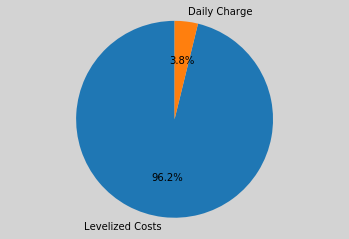

ERROR:ga_logger:panel values: (244.38498220895193, 140.1382120111922, 106.01062641186591, 1.673183190216765, 2.4708484261546113, 1.9133551800417177, 0.8561799430926289, 0.8991964189556179, 0.8894673685075216)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 244
                                           a tilt of 1.7
                                           and a gcr of 0.856


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.775159120559692 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 2.5
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.738362789154053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 1.9
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.666583299636841 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 294 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 331.23416967318025, 0.0]


ERROR:ga_logger:Cost: 3422.9404369398885


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


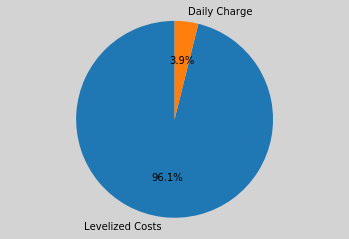

ERROR:ga_logger:panel values: (213.16518556343124, 167.2803350077968, 148.01445776593965, 8.849484768793554, 35.25219671909243, 34.41774549624986, 0.8768105435114015, 0.8927272422285171, 0.2039049480391813)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 213
                                           a tilt of 8.8
                                           and a gcr of 0.877


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.121593475341797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 35.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.440705060958862 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 34.4
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.618337154388428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 295 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [257.21467470395555, 0.0, 62.27441769906307]


ERROR:ga_logger:Cost: 3306.2859911567625


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


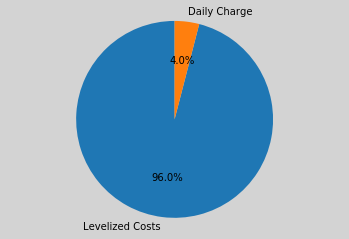

ERROR:ga_logger:panel values: (212.7371844422034, 194.5975748804648, 168.0122512391024, 33.25063815326156, 31.474336796129972, 36.04844197470848, 0.6591028574230593, 0.6254830835696055, 0.43782100447135786)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 213
                                           a tilt of 33.3
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.102282762527466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 31.5
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.662510395050049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 36.0
                                           and a gcr of 0.438


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.563718557357788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  32 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 295 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 121.67371960168323, 176.98217390309216]


ERROR:ga_logger:Cost: 3099.3665129865976


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


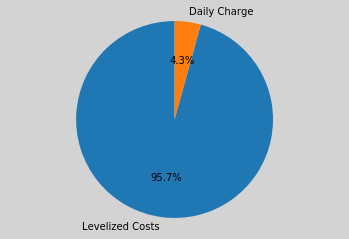

ERROR:ga_logger:panel values: (204.18088486072435, 182.25078445099263, 165.88207635752346, 35.17666521063363, 36.68488825981225, 29.14895996713283, 0.5794516247223072, 0.7753961669570137, 0.48281050088346195)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 35.2
                                           and a gcr of 0.579


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.798874616622925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 36.7
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.242025375366211 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 29.1
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.365508794784546 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 22.396552183245138, 275.14292290348396]


ERROR:ga_logger:Cost: 3088.2780185932547


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


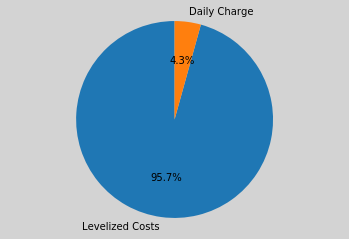

ERROR:ga_logger:panel values: (187.63908614699233, 196.48341022599055, 176.06154497618297, 33.61341898860611, 30.830052420445853, 28.41586290214546, 0.5683557125341181, 0.6383317833188032, 0.49964270568448554)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 188
                                           a tilt of 33.6
                                           and a gcr of 0.568


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.531077861785889 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 30.8
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.044692754745483 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 28.4
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.217646598815918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 310 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.5606997653706]


ERROR:ga_logger:Cost: 3068.624425722628


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


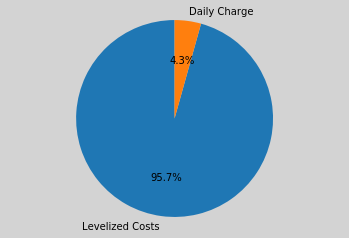

ERROR:ga_logger:panel values: (261.81078748062964, 257.77882369756486, 263.14474733311965, 3.2943924188051934, 54.90127781143878, 55.49508874181565, 0.8974755106908785, 0.8796242562156538, 0.8937186799931516)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 3.3
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.0579986572265625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 54.9
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2479777336120605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 55.5
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.261044025421143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 326 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [337.05198162683763, 0.0, 0.0]


ERROR:ga_logger:Cost: 3480.724107413015


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


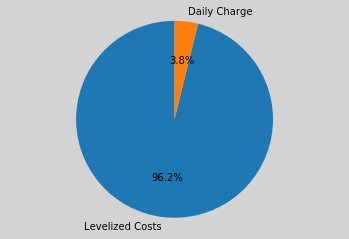

ERROR:ga_logger:panel values: (134.5808479052142, 99.12377488311337, 164.9928098625267, 50.516796629264434, 1.6734522466465631, 55.64628981935012, 0.86051926064807, 0.894433102642511, 0.28602328132271704)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 50.5
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.8262529373168945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 1.7
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.023587226867676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 55.6
                                           and a gcr of 0.286


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.258477210998535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 330 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 229.6704844366587, 97.81537740697868]


ERROR:ga_logger:Cost: 3385.711504859108


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


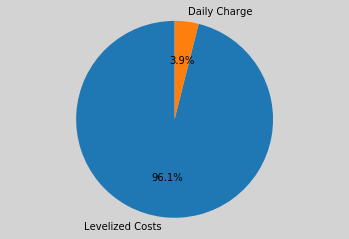

ERROR:ga_logger:panel values: (261.1971324703831, 153.1133999009133, 160.99844595350677, 1.785554309548414, 54.28810580874572, 34.05012225865042, 0.6205662851648373, 0.8903071558668159, 0.8655988627858384)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 1.8
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.421084403991699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 153
                                           a tilt of 54.3
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.988980531692505 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 34.1
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.178332328796387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 320 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.66812304680127]


ERROR:ga_logger:Cost: 3387.521781802522


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


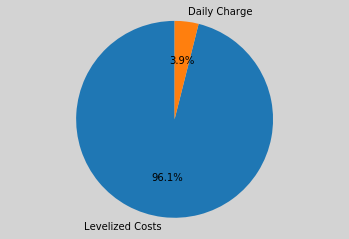

ERROR:ga_logger:panel values: (203.99986335997036, 196.5573461567571, 166.1525081456985, 38.68326095817234, 28.465969649300334, 32.61421979957446, 0.5618459459585174, 0.720664492761169, 0.38543525560736525)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 38.7
                                           and a gcr of 0.562


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.643438100814819 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 28.5
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.248214960098267 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 32.6
                                           and a gcr of 0.385


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.246057748794556 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 329 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 151.28703526704578, 149.87054108850234]


ERROR:ga_logger:Cost: 3124.2137247270575


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


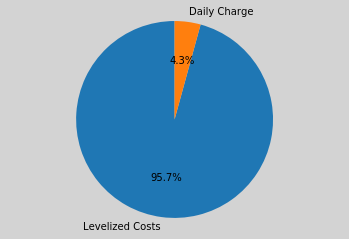

ERROR:ga_logger:panel values: (179.0216632915829, 205.14512575643545, 183.56715561509537, 31.088464482666684, 29.073993804315375, 25.494714733885978, 0.5633833365257911, 0.6162105258038635, 0.5438013402386842)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 31.1
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.718196630477905 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 29.1
                                           and a gcr of 0.616


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.264266490936279 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 25.5
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.219886779785156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 324 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.6617046721824]


ERROR:ga_logger:Cost: 3079.5598249017853


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


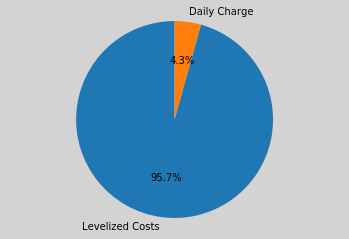

ERROR:ga_logger:panel values: (201.46631179203195, 186.5439664656489, 172.6710929654311, 36.80454894746292, 36.804343542506665, 33.686278253860934, 0.5958578737192997, 0.6622457932539866, 0.45086287163022737)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 36.8
                                           and a gcr of 0.596


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.666221857070923 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 36.8
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.082938194274902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 33.7
                                           and a gcr of 0.451


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.135293245315552 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 319 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 85.99644689510606, 211.4122591831427]


ERROR:ga_logger:Cost: 3086.979199001476


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


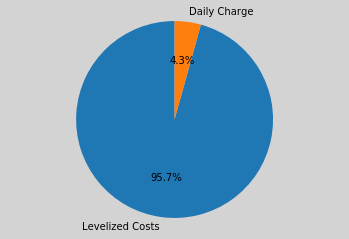

ERROR:ga_logger:panel values: (209.1202430821668, 208.43873749614733, 189.8827102081222, 42.527704185088865, 27.911793212197736, 26.202052264657627, 0.43129451476685976, 0.6017477458325442, 0.5368289685766788)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 42.5
                                           and a gcr of 0.431


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.742025375366211 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 27.9
                                           and a gcr of 0.602


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.902990102767944 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 26.2
                                           and a gcr of 0.537


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.121477127075195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  29 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 331 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.594415516773]


ERROR:ga_logger:Cost: 3088.8236956322876


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


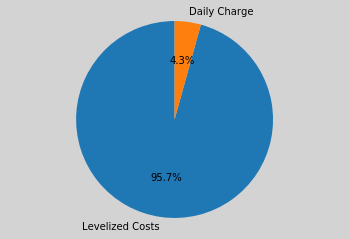

ERROR:ga_logger:panel values: (172.71410396799865, 202.74510830099211, 188.49151362570086, 36.838837111243706, 30.388817113888916, 24.379994076548165, 0.5257162763427898, 0.65643741816044, 0.4274751506683768)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 36.8
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.0111610889434814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 30.4
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.116349220275879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 24.4
                                           and a gcr of 0.427


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.173899412155151 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 334 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [225.07802401079206, 0.0, 72.93827103301436]


ERROR:ga_logger:Cost: 3093.013893071709


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


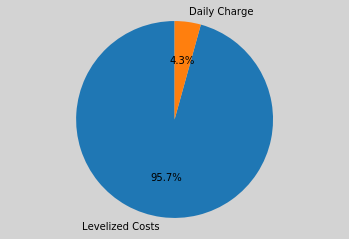

ERROR:ga_logger:panel values: (180.48633487007186, 213.03282420197618, 181.73592529312924, 35.62545445843165, 27.507713880491295, 30.376450365363073, 0.5452848136348368, 0.6298120212026856, 0.46450771890254405)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 35.6
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.9165425300598145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 27.5
                                           and a gcr of 0.630


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.887429237365723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.4
                                           and a gcr of 0.465


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.018980264663696 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 340 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [111.27869744240692, 0.0, 183.33526628120632]


ERROR:ga_logger:Cost: 3059.2212575684853


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


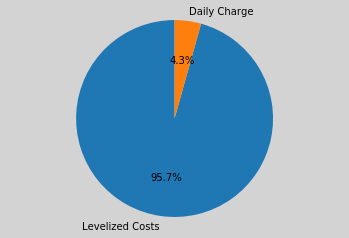

ERROR:ga_logger:panel values: (186.15118213299104, 210.78970519916842, 184.4844414877017, 33.349053567872666, 28.454172426598497, 28.717822385102146, 0.5290954660283643, 0.6576165229028194, 0.4624869446776657)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 33.3
                                           and a gcr of 0.529


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.5591418743133545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 28.5
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.021960973739624 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 28.7
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.12257981300354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 339 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [145.12454794831808, 0.0, 150.06483203013724]


ERROR:ga_logger:Cost: 3064.936405575418


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


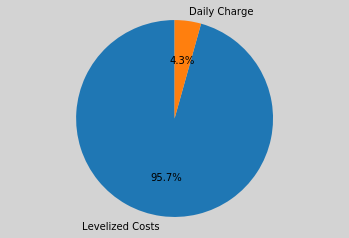

ERROR:ga_logger:panel values: (184.24482480056952, 209.6227572505394, 185.60981974146063, 34.69435236312043, 27.974912350913765, 28.866984875747654, 0.5404646116003882, 0.6672289195203776, 0.4744698364965454)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 34.7
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.252662181854248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 28.0
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.154808759689331 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 28.9
                                           and a gcr of 0.474


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.075048208236694 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 344 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [91.00393703201667, 0.0, 204.20268192279184]


ERROR:ga_logger:Cost: 3065.1076262647666


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


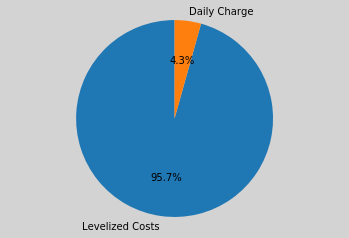

ERROR:ga_logger:panel values: (108.28553423812954, 264.10547147695615, 261.0358880644435, 51.6688907720838, 1.1987981590780552, 54.42484581344167, 0.8999628656700558, 0.8969006741525447, 0.8871883042986455)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 108
                                           a tilt of 51.7
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.763442277908325 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.2
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.7720301151275635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 54.4
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.177008152008057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 347 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 336.2397387926683, 0.0]


ERROR:ga_logger:Cost: 3472.6567487400703


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


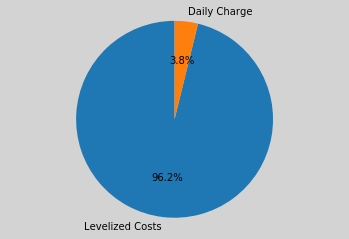

ERROR:ga_logger:panel values: (173.45811722017294, 186.20832290659007, 90.81500006792761, 43.50922462982842, 3.9523674442409966, 54.99873624928367, 0.899682380410215, 0.8988162899163212, 0.8977227347542642)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 43.5
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.689022541046143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 4.0
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.311837434768677 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 55.0
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.297042369842529 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 342 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 327.0229363580843, 0.0]


ERROR:ga_logger:Cost: 3381.1136279773177


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


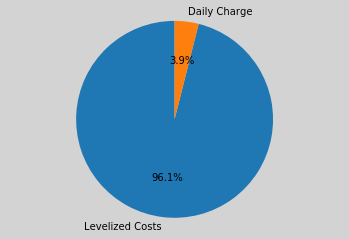

ERROR:ga_logger:panel values: (263.8286394082135, 150.32072843534544, 258.09753982163465, 23.139725634944732, 4.703712427714965, 42.94183662299839, 0.8965076273364339, 0.8931179290575548, 0.44167934202119263)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 23.1
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.895244598388672 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 4.7
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.178230047225952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 42.9
                                           and a gcr of 0.442


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.26607084274292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 339 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 327.6034624047182, 0.0]


ERROR:ga_logger:Cost: 3386.8795289728914


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


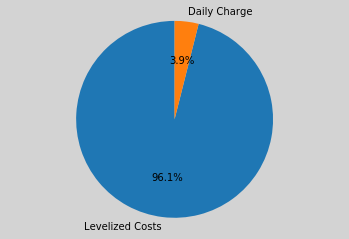

ERROR:ga_logger:panel values: (206.50072495555776, 205.0647135941573, 180.3152343044772, 37.07263758274636, 30.140929288116013, 29.325560416367168, 0.5051825397450083, 0.651010064703131, 0.5637290445521402)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 37.1
                                           and a gcr of 0.505


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.902428388595581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 30.1
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.149637222290039 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.3
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.242551326751709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 339 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.0193376348316]


ERROR:ga_logger:Cost: 3073.179710760561


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


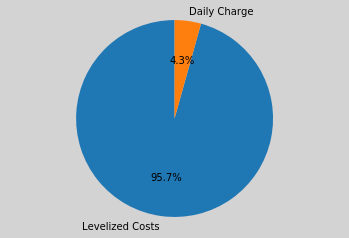

ERROR:ga_logger:panel values: (185.82758505157716, 215.59830521723612, 174.88739868142483, 42.210209129691556, 27.0925689869116, 37.83532926785342, 0.5491133732953757, 0.5176887864100996, 0.5000935469507475)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 42.2
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.895260810852051 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 27.1
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3736042976379395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 37.8
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.955708265304565 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 322 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.8493782941323]


ERROR:ga_logger:Cost: 3091.3560456467394


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


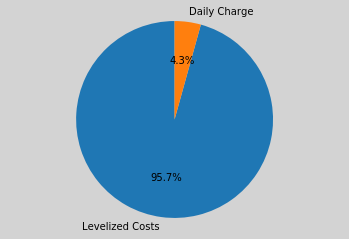

ERROR:ga_logger:panel values: (190.91701534106846, 173.33140995414374, 181.83855155290786, 13.635776617153603, 28.599044935549543, 18.453107190926126, 0.8872116442129938, 0.3996459909751211, 0.7368755896392947)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 13.6
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.8865087032318115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 28.6
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.332558631896973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 18.5
                                           and a gcr of 0.737


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.352956295013428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 325 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 168.82911825617052, 129.92222747583898]


ERROR:ga_logger:Cost: 3100.3145561496917


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (101.2687203113556, 260.91870339396286, 260.14174939669624, 1.8790175941471738, 1.4096387699582023, 55.325085996951266, 0.8980257965809089, 0.2138656324083208, 0.8984434435160309)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 1.9
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.4312591552734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 1.4
                                           and a gcr of 0.214


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.90306544303894 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 55.3
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.111522436141968 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 314 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [335.0834574740328, 0.0, 0.0]


ERROR:ga_logger:Cost: 3461.172331916149


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


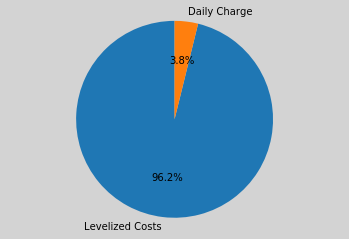

ERROR:ga_logger:panel values: (115.48732323097087, 264.82924574119454, 153.6666297670616, 8.42160577083348, 55.247702788197145, 55.31851267849203, 0.8973473699684322, 0.5360122430247718, 0.8797300528914809)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 8.4
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.091914176940918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 55.2
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.364730358123779 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 55.3
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.887284278869629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 324 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [336.3980708802753, 0.0, 0.0]


ERROR:ga_logger:Cost: 3474.2293390758696


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (242.15418429703735, 257.3852842646676, 264.22750712059894, 31.284456920433342, 25.505626190035795, 53.801183846282704, 0.8816991817115025, 0.3615769858760288, 0.8958605581176617)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 31.3
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.178804159164429 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 25.5
                                           and a gcr of 0.362


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.019951343536377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 53.8
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1625730991363525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 327 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [250.78196403516068, 113.65499285186915, 0.0]


ERROR:ga_logger:Cost: 3752.7172099973805


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


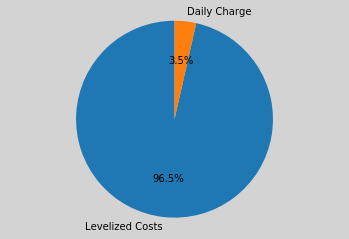

ERROR:ga_logger:panel values: (185.1905104211761, 208.4870351929182, 177.5600729666519, 37.15515163340274, 28.841102176786166, 29.96504563225718, 0.44782755116150064, 0.6184672431412435, 0.5197036036196716)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 37.2
                                           and a gcr of 0.448


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.265681028366089 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 28.8
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.299839735031128 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 30.0
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.323315143585205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 321 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [97.0588787054918, 0.0, 198.54183309055193]


ERROR:ga_logger:Cost: 3069.021836262784


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


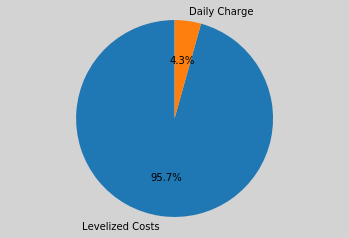

ERROR:ga_logger:panel values: (183.33206772476072, 212.01730390899056, 177.54117124143147, 35.578891244533864, 28.989792112131372, 31.660580955589744, 0.5162606892720871, 0.6247165658523093, 0.4811130171241793)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 35.6
                                           and a gcr of 0.516


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.027985572814941 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 29.0
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.217934846878052 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 31.7
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.199961185455322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 323 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [105.25556465703389, 0.0, 189.98240454064128]


ERROR:ga_logger:Cost: 3065.4190049466065


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


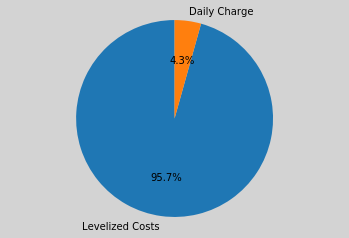

ERROR:ga_logger:panel values: (176.60676343618587, 209.38061975527552, 182.09173423004012, 36.32723455961149, 25.786140276031283, 30.273943834807078, 0.5338844385582471, 0.621205549641977, 0.4823900146358917)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 36.3
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.164356470108032 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 209
                                           a tilt of 25.8
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.086958646774292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.3
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.123969316482544 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 342 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [62.47794458013503, 0.0, 232.38485792345935]


ERROR:ga_logger:Cost: 3061.69277325344


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


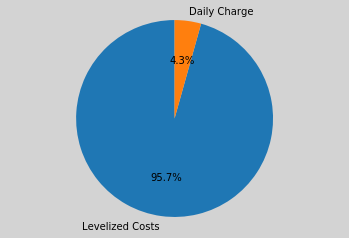

ERROR:ga_logger:panel values: (90.68222328141069, 264.8057302827425, 257.98963098081094, 1.2568345262204719, 37.80885099535973, 52.94504187849942, 0.8895725457449757, 0.36297119432023295, 0.2044430838844333)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.3
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.452029466629028 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 37.8
                                           and a gcr of 0.363


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.46631383895874 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 52.9
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.482414245605469 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 375 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [335.9163294603389, 0.0, 0.0]


ERROR:ga_logger:Cost: 3469.444582667743


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


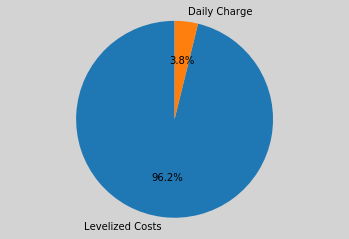

ERROR:ga_logger:panel values: (91.04564412956108, 100.75098262959203, 246.15620360693148, 1.1016552068017573, 1.7379584170108444, 1.9665346566693778, 0.8898708291488655, 0.5073495808592069, 0.882981993181905)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.1
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.593724727630615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 1.7
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.283403158187866 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 246
                                           a tilt of 2.0
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.221322774887085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 344 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.6011015029989]


ERROR:ga_logger:Cost: 3456.381476072473


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


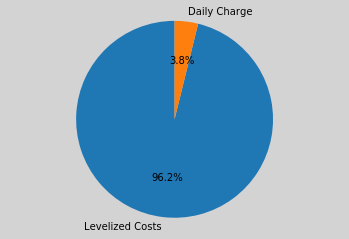

ERROR:ga_logger:panel values: (191.25295776364894, 91.24569475134159, 210.02765706960707, 1.4759286626441845, 44.78310874674691, 8.497266002662657, 0.8850483340792568, 0.882389290846703, 0.5706191437536816)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 1.5
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.881983518600464 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 44.8
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.321730136871338 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 8.5
                                           and a gcr of 0.571


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.37269926071167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 349 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.87606913103264]


ERROR:ga_logger:Cost: 3300.1973168747036


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


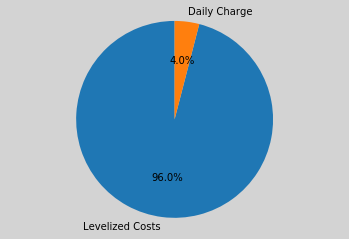

ERROR:ga_logger:panel values: (199.6490587882111, 194.39722877347555, 168.41004594014848, 26.887126109852034, 35.18363361105932, 21.9366397883816, 0.453772928104391, 0.7121455443404703, 0.5512919983081066)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 26.9
                                           and a gcr of 0.454


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.5991315841674805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 35.2
                                           and a gcr of 0.712


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.697253465652466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 21.9
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.369098424911499 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 341 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [143.92102571384075, 0.0, 155.24183310632014]


ERROR:ga_logger:Cost: 3104.401785587475


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


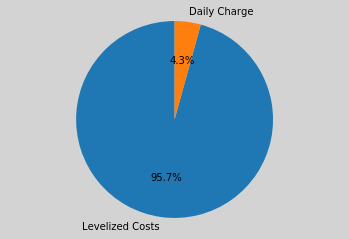

ERROR:ga_logger:panel values: (191.9856497817279, 204.45448669977225, 182.31388373457517, 40.46264506507363, 28.251986521972185, 29.917306372170046, 0.5479927698993725, 0.5885521234640007, 0.5227181892157917)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 40.5
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.614430665969849 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 28.3
                                           and a gcr of 0.589


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.592155933380127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 29.9
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.844889402389526 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 344 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.06536848114973]


ERROR:ga_logger:Cost: 3063.704698230754


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


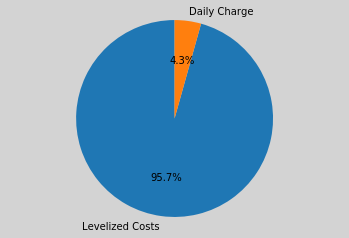

ERROR:ga_logger:panel values: (191.76960842156464, 204.65571654307314, 183.98773768291588, 37.570025653558076, 28.008962319928248, 28.39279206695619, 0.4934378759324499, 0.6169674622724932, 0.5145730448562242)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 37.6
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.7150843143463135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 28.0
                                           and a gcr of 0.617


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.696838855743408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 28.4
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.854328870773315 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 331 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.29871227600114]


ERROR:ga_logger:Cost: 3066.0223139989753


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


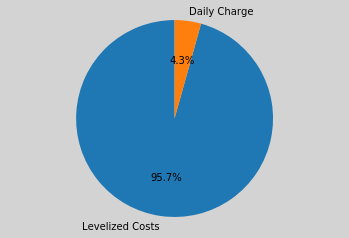

ERROR:ga_logger:panel values: (176.43129900461372, 220.6463265632586, 184.17168995160964, 34.536949131845, 28.711086033793645, 28.98629950071284, 0.5517053839088515, 0.6181837216280988, 0.4958570086434972)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 34.5
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.796719312667847 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 28.7
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.423201322555542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 29.0
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.430670976638794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 327 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 294.7756385317015]


ERROR:ga_logger:Cost: 3060.827041229734


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


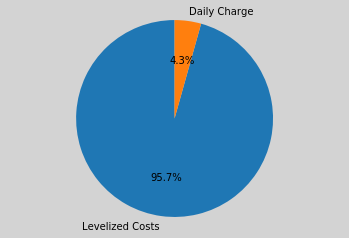

ERROR:ga_logger:panel values: (177.85641699026104, 210.8853152527223, 185.9757888106505, 35.92252563460749, 28.627253839566976, 30.610035898745537, 0.5417691170351107, 0.6245927885222367, 0.45687753706779877)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 35.9
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.441071033477783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 28.6
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.238194942474365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 30.6
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.572825908660889 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 294 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [143.72441933000005, 0.0, 152.35699354357794]


ERROR:ga_logger:Cost: 3073.796256269423


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


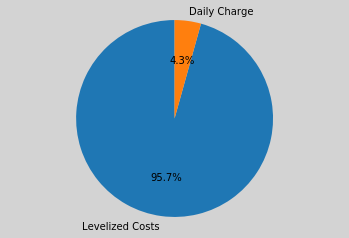

ERROR:ga_logger:panel values: (179.46655035067943, 213.39294813914077, 179.83257957166296, 36.01646039111638, 27.66266661826012, 29.71862688346669, 0.5427544823973557, 0.6321100491132562, 0.46105773322305355)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 36.0
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.664339065551758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 27.7
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.160592079162598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.7
                                           and a gcr of 0.461


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.277225494384766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 285 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [132.94610221211718, 0.0, 163.12897788566283]


ERROR:ga_logger:Cost: 3073.7333573499136


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


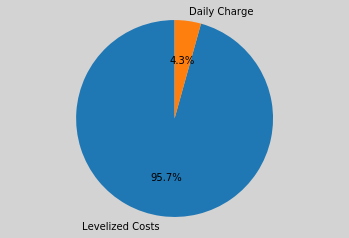

ERROR:ga_logger:panel values: (180.90922367123596, 214.1027224294903, 182.44703227940056, 35.695198532347106, 27.274944322960632, 30.554761260567336, 0.5431587698349634, 0.6308798428363254, 0.46417404054612504)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 35.7
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.112162113189697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 214
                                           a tilt of 27.3
                                           and a gcr of 0.631


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.064408540725708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.6
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.033820629119873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 251 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [115.43990985833719, 0.0, 179.27668912030097]


ERROR:ga_logger:Cost: 3060.2406515826815


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (180.42470024833838, 212.93522388686438, 181.6018782536833, 35.451747346233375, 27.442877196981232, 30.523940982941692, 0.5468346270208011, 0.6301113363126095, 0.46510251002806197)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 35.5
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.677546977996826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 27.4
                                           and a gcr of 0.630


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.045307874679565 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.5
                                           and a gcr of 0.465


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.168195724487305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  29 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 257 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [107.55192858678613, 0.0, 187.00877886543253]


ERROR:ga_logger:Cost: 3058.692305608084


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (94.59767703645495, 263.91766960502787, 124.42282659117919, 4.0441307207800445, 1.990487134205329, 6.882493999794566, 0.888071611135264, 0.496032951933643, 0.8353701126860091)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 4.0
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.15514349937439 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 2.0
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.83608603477478 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 6.9
                                           and a gcr of 0.835


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1565515995025635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 292 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.06450169176355]


ERROR:ga_logger:Cost: 3401.3908635046582


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (223.74297944910532, 91.81351576592711, 97.60966092302884, 50.89194858558719, 16.136280614218037, 10.763178065848441, 0.8969809760727863, 0.8997817798611125, 0.6629817039316732)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 50.9
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.009699821472168 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 16.1
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.201582193374634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 10.8
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.168449878692627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.11059742733687]


ERROR:ga_logger:Cost: 3471.3740932227256


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (123.10679144062172, 215.46832487986927, 161.9504755261302, 25.753096076312964, 5.149905550656365, 41.19922336298785, 0.8856972691988707, 0.5131071857642311, 0.8612935342046457)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 123
                                           a tilt of 25.8
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.2895283699035645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 5.1
                                           and a gcr of 0.513


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.044895887374878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 41.2
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.004425287246704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 298 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 278.5477205492339, 48.143805691787776]


ERROR:ga_logger:Cost: 3377.822001446846


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


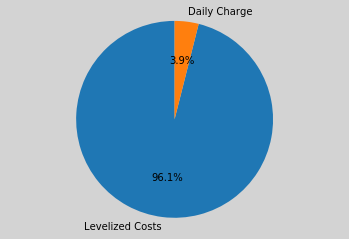

ERROR:ga_logger:panel values: (190.20814971316997, 219.13294261792282, 183.49040181178864, 32.72071216913353, 23.839883633452438, 33.23541645014466, 0.5505613980779471, 0.5278523525296943, 0.5750856236593561)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 32.7
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.847375154495239 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 23.8
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.260400295257568 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 33.2
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.410952091217041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


In [28]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10 )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10)
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i)+10)
    pvoptimizer.processGA(ga_fina)

